# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Web-Scraping"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Web Scraping</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span></a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span></a></div></p>

In [1]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.
URL_top_uni = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508076958348'
URL_top_uni2 = 'https://www.topuniversities.com'
URL_tim_high = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

## Task 1. Web Scraping

The `DATA_FOLDER/final_df.pkl` is a pickle files that contains all the extracted data from www.topuniversities.com. We decided to store our data in a file because collecting data from that website required a lot of time. Doing this way we can load everything in a small time.

### Useful functions

#### Here we introduce and explain some useful functions that we made for handling the datasets:

<ul>
<li> **convert_to_numbers**(string): <p>It simply takes a string and returns only the digit as a float

<li> **retrieve_university_data**(url, list_, university_name): <p> This method is used in order to obtain the data regarding the staff and the students from the specific page of a university in the _TopUniversities_ site. First, we request the site with the "url" argument, then, using the "find" method from BeautifulSoup we get the data that we are interested in. We used DOM inspection from the browser to understand wich tags and attributes were useful for our research. Some universities sites could not have the objects that we were looking for, therefore we treated the Exceptions in order to not have a failure in the program (in that case we assign a NaN value).

<li> **clean_matches**(names, matches, outliers_list): <p>After matching the names of the two universities with difflib.get_close_matches, we observed that a lot of errors occured during the execution of this last function. So we created clean_matches() in order to "clean" all these errors. It takes as parameters two series, the first one is the series containing the names of the universities from one of the two websites (ex: top universities), the second one is the corresponding match (ex: the match found in times higher education of the name Oxford from top universities). The third parameter is a list of strings that can be substrings of the elements of names and matches: we replace these substrings with "" if we find them because they increase the percentage of finding a good match when it is not. For example: "The Technological University of ADA" is very similar to "The Technological University of Bob", but if we delete the substring "The Technological University of" the two remaining strings will be very different and so we can notice that the match was wrong. It returns a dataframe with two columns: the name column as it was given and the match column cleaned of all the errors (NaN filling the wrong values). For more details, please look at the comments in the code.


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from numpy import NaN
import re
%matplotlib inline
import matplotlib.pyplot as plt
import difflib

def convert_to_numbers(string):
    return pd.to_numeric(re.sub("\D", "", string))


def retrieve_university_data(url, list_, university_name):

    international_staff = NaN
    total_staff = NaN
    international_students = NaN
    total_students = NaN

    #here we make the request and we parse with BeautifulSoup
    req = requests.get(url)
    soup = BeautifulSoup(req.text, 'html.parser')

    
    #Here we search for the data regarding the staff of the university
    faculty_staff_wrapper = soup.find('div', class_ = 'faculty-main')
    try:
        total_staff = convert_to_numbers(faculty_staff_wrapper.find('div', class_='total')
                                         .find('div', class_ = 'number')
                                         .text)
    except:
        print('value not found in total staff ' + university_name)
        
    try:
        international_staff = convert_to_numbers(faculty_staff_wrapper.find('div', class_='inter')
                                                 .find('div', class_='number')
                                                 .text)
    except:
        print('value not found in international staff ' + university_name)

    
    #here we do the same for the total number of students
    total_students_wrapper = soup.find('div', class_ = 'students-main')
    try:
        total_students = convert_to_numbers(total_students_wrapper.find('div', class_='total')
                                            .find('div', class_='number')
                                            .text)
    except:
        print('value not found in total students' + university_name)

    # Search for international students data
    international_students_wrapper = soup.find('div', class_='int-students-main')
    try:
        international_students = convert_to_numbers(international_students_wrapper.find('div', class_='total')
                                                    .find('div', class_='number')
                                                    .text)
    except:
        print('value not found in international students' + university_name)
    
    # Finally, we append to the list a dictionary with the values found
    list_.append({'title': university_name,
                              'international_staff': international_staff,
                              'total_staff': total_staff,
                              'international_students': international_students,
                              'total_students': total_students})


def clean_matches(names, matches, outliers_list):

    final_df = pd.DataFrame()

    '''
    The word "The" is replaced in every name since it is not particular of any university
    '''
    for name, match in zip(names, matches):
        if 'The ' in name:
            name = name.replace('The ', '')
            #Why not match.replace????

        outliers_found_list = []

        '''
        If we find one outlier in both the match and the name, we append it to the list of outliers found
        '''
        for elem in outliers_list:
            if match is not NaN and elem in name and elem in match:
                outliers_found_list.append(elem)

        '''
        We retrive the longest outlier in order to replace it with ""
        '''
        if len(outliers_found_list) > 0:
            longest_out = max(outliers_found_list, key=len)

            '''
            The longest outlier is splitted in all the words that is made of
            '''
            splitted = longest_out.split()

            temp_name = name
            temp_match = match
            
            '''
            We get the new strings without the outlier
            '''
            for word in splitted:
                temp_name = temp_name.replace(word, '')
                temp_match = temp_match.replace(word, '')


            '''
            We cancel everything inside the parenthesis because is not useful.
            We are deleting every possible abbreviation of the universities
            '''
            start_name = temp_name.find('(')
            start_match = temp_match.find('(')
            end_name = temp_name.find(')')
            end_match = temp_match.find(')')

            if start_name != -1 and end_name != -1:
                temp_name = temp_name.replace(temp_name[start_name: end_name +1], '')


            if start_match != -1 and end_match != -1:
                temp_match = temp_match.replace(temp_match[start_match: end_match + 1], '')


            '''
            If after all these steps the match is good at least for the 86%, we keep it.
            We chose the percentage (86%) empirically. This percentage gives us a perfect match everywhere.
            If the match is under the threshold, we put NaN instead of the match
            '''
            if difflib.SequenceMatcher(None, temp_name, temp_match).ratio() > 0.86:
                new_row = pd.Series([name, match])
                final_df = final_df.append(new_row, ignore_index=True)
            else:
                new_row = pd.Series([name, NaN])
                final_df = final_df.append(new_row, ignore_index=True)
            
            '''
            If we didn't find any outlier then the match was good 
            (only names containg outliers gave problems of wrong matches)
            '''
        else:
            new_row = pd.Series([name, match])
            final_df = final_df.append(new_row, ignore_index=True)
        


    final_df.columns = ['name', 'match']

    return final_df

### Top Universities Scraping

#### Actual web scraping

This is the script that retrieves all the data from the website. It takes several minutes to find everything we need, so if you want to try it, let it run, go and grab a cup of coffee!

**DESCRIBING THE PROCESS**
<ul>
<li> First, we used postman with the postman interceptor in order to understand where the data of the main page were dynamically loaded and we saved the link in the **URL_top_uni** variable.
<li>After having done the request to the **URL_top_uni**, we read the data as Json file and then we create the dataframe.
<li>Then we reorder the columns, we convert the type of the rank column to int and we selected the first 200 universities (they were already ordered by rank).
<li>For each university (each row of our dataframe) we call the **retrieve_university_data** method and for each iteration we append the returned dictionary to a temporary list ("temp_list"). As you can see, we used "zip(dataframe1.title, dataframe1.url)" to obtain the name and the url for each university. 
<li>Completed the cycle, we create a second dataframe using "temp_list" as argument for the **pd.Dataframe.from_dict** method. This dataframe has as columns: name, total_staff, international_staff, total_students, international_students. 
<li>Finally we merge the new dataframe with the first dataframe by the 'title' columns.

In [18]:
# URL_top_uni = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508076958348'
#
# r = requests.get(URL_top_uni)
#
# dataframe = pd.DataFrame(r.json())
#
# dict = dataframe['data']
#
# dataframe = pd.concat([dataframe, dict.apply(pd.Series)], axis=1)
#
# dataframe = dataframe.drop('data', axis = 1)
#
# dataframe1 = dataframe[['country', 'region', 'title', 'rank_display', 'url', 'guide']]
#
# dataframe1.loc[:,'rank_display'] = dataframe1.rank_display.str.extract('(\d+)').astype(int)
#
# dataframe1 = dataframe1.head(200)
#
# URL_top_uni2 = 'https://www.topuniversities.com'
#
# temp_list = []
# for name, url in zip(dataframe1.title, dataframe1.url):
#
#     retrieve_university_data(URL_top_uni2 + url, temp_list, name)
#
# second_df = pd.DataFrame.from_dict(temp_list)
#
# tu_df = dataframe1.merge(second_df, left_on ='title', right_on ='title', how ='outer')
#
# tu_df = tu_df[['country', 'region', 'title', 'rank_display', 'international_staff', 'total_staff', 'international_students', 'total_students']]
#
# tu_df.to_pickle('final_df.pkl')

- We read the pickle file in top_univ_df, we set the index and then we rename every columns with the prefix TU (Top Universities). Then we calculate the ratio between staff and students and between internation students and total students

In [82]:
top_univ_df = pd.read_pickle('Data/final_df.pkl')

columns_dict = {'title' : 'name', 'country' : 'TU_country', 'region' : 'TU_region', 'rank_display' : 'TU_rank',
                'international_staff' : 'TU_international_staff', 'total_staff' : 'TU_total_staff',
                'international_students' : 'TU_international_students', 'total_students' : 'TU_total_students'}

top_univ_df = top_univ_df.rename(columns = columns_dict)

top_univ_df = top_univ_df.set_index('name')

top_univ_df['TU_ratio_staff_students'] = top_univ_df.TU_total_staff / top_univ_df.TU_total_students
top_univ_df['TU_ratio_international_students'] = top_univ_df.TU_international_students / top_univ_df.TU_total_students

In [83]:
top_univ_df.head(4)

,TU_country,TU_region,TU_rank,TU_international_staff,TU_total_staff,TU_international_students,TU_total_students,TU_ratio_staff_students,TU_ratio_international_students
name,,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,North America,1,1679.0,2982.0,3717.0,11067.0,0.269450,0.335863
Stanford University,United States,North America,2,2042.0,4285.0,3611.0,15878.0,0.269870,0.227422
Harvard University,United States,North America,3,1311.0,4350.0,5266.0,22429.0,0.193945,0.234785
California Institute of Technology (Caltech),United States,North America,4,350.0,953.0,647.0,2255.0,0.422616,0.286918


### Best universities in term of ratio between faculty members and students

- Ordering the top_univ_df for descending values of ratio staff/students

In [84]:
df_ratio_staff_students = top_univ_df.sort_values('TU_ratio_staff_students', ascending=False)
df_ratio_staff_students.head(4)

,TU_country,TU_region,TU_rank,TU_international_staff,TU_total_staff,TU_international_students,TU_total_students,TU_ratio_staff_students,TU_ratio_international_students
name,,,,,,,,,
California Institute of Technology (Caltech),United States,North America,4,350.0,953.0,647.0,2255.0,0.422616,0.286918
Yale University,United States,North America,16,1708.0,4940.0,2469.0,12402.0,0.398323,0.199081
University of Oxford,United Kingdom,Europe,6,2964.0,6750.0,7353.0,19720.0,0.342292,0.372870
University of Cambridge,United Kingdom,Europe,5,2278.0,5490.0,6699.0,18770.0,0.292488,0.356899


- Below you can see the countries in terms of staff/students:

In [85]:
top_univ_df.groupby("TU_country").mean().sort_values(by="TU_ratio_staff_students", ascending=False).head(5)

,TU_rank,TU_international_staff,TU_total_staff,TU_international_students,TU_total_students,TU_ratio_staff_students,TU_ratio_international_students
TU_country,,,,,,,
Russia,95.000000,373.000000,6709.0,5098.000000,30233.000000,0.221910,0.168624
Denmark,102.666667,1301.333333,3972.0,3181.000000,22407.666667,0.186580,0.164809
Saudi Arabia,173.000000,665.000000,1062.0,989.000000,6040.000000,0.175828,0.163742
Singapore,13.000000,3039.500000,4722.0,8084.000000,29233.000000,0.162279,0.277091
Japan,90.777778,246.777778,3155.0,1807.666667,20691.333333,0.155840,0.090000


- Next, we have a dataframe of best regions in terms of staff/students:

In [86]:
top_univ_df.groupby("TU_region").mean().sort_values(by="TU_ratio_staff_students", ascending=False)

,TU_rank,TU_international_staff,TU_total_staff,TU_international_students,TU_total_students,TU_ratio_staff_students,TU_ratio_international_students
TU_region,,,,,,,
North America,81.092593,827.094340,3436.283019,5511.622642,29176.471698,0.144831,0.202437
Asia,88.657895,688.162162,2808.789474,2897.368421,21236.921053,0.134673,0.132394
Europe,114.595506,759.528090,2453.460674,5049.033708,21991.584270,0.120003,0.245932
Latin America,148.142857,806.857143,6483.142857,5267.285714,62250.000000,0.096779,0.071751
Africa,191.000000,379.000000,1733.000000,3325.000000,19593.000000,0.088450,0.169703
Oceania,79.454545,1162.363636,2304.272727,10799.818182,31833.363636,0.075003,0.329077


### Best universities in term of ratio between faculty members and students

- Ordering the top_univ_df for descending values of ratio international/tot_students.

In [87]:
df_ratio_intern_students = top_univ_df.sort_values('TU_ratio_international_students', ascending=False)
df_ratio_intern_students.head()

,TU_country,TU_region,TU_rank,TU_international_staff,TU_total_staff,TU_international_students,TU_total_students,TU_ratio_staff_students,TU_ratio_international_students
name,,,,,,,,,
London School of Economics and Political Science (LSE),United Kingdom,Europe,35,687.0,1088.0,6748.0,9760.0,0.111475,0.691393
Ecole Polytechnique Fédérale de Lausanne (EPFL),Switzerland,Europe,12,1300.0,1695.0,5896.0,10343.0,0.163879,0.570047
Imperial College London,United Kingdom,Europe,8,2071.0,3930.0,8746.0,16090.0,0.244251,0.543567
Maastricht University,Netherlands,Europe,200,502.0,1277.0,8234.0,16385.0,0.077937,0.502533
Carnegie Mellon University,United States,North America,47,425.0,1342.0,6385.0,13356.0,0.100479,0.478062


- next, the first best countries in terms of ratio of international/tot_students:

In [88]:
top_univ_df.groupby("TU_country").mean().sort_values(by="TU_ratio_international_students", ascending=False).head(5)

,TU_rank,TU_international_staff,TU_total_staff,TU_international_students,TU_total_students,TU_ratio_staff_students,TU_ratio_international_students
TU_country,,,,,,,
United Kingdom,87.928571,1079.142857,2854.785714,7122.357143,20843.607143,0.135913,0.351308
Australia,71.222222,1264.666667,2448.222222,11817.666667,33554.888889,0.076407,0.346878
Switzerland,93.571429,1315.428571,2189.000000,4713.571429,15587.428571,0.134872,0.313816
Hong Kong,49.200000,1259.200000,2033.200000,4899.800000,15767.600000,0.128988,0.312148
Austria,168.000000,786.000000,2058.500000,9833.500000,31723.000000,0.057298,0.306095


- best regions in terms of ratio of international/tot_students:

In [89]:
top_univ_df.groupby("TU_region").mean().sort_values(by="TU_ratio_international_students", ascending=False).head(5)

,TU_rank,TU_international_staff,TU_total_staff,TU_international_students,TU_total_students,TU_ratio_staff_students,TU_ratio_international_students
TU_region,,,,,,,
Oceania,79.454545,1162.363636,2304.272727,10799.818182,31833.363636,0.075003,0.329077
Europe,114.595506,759.528090,2453.460674,5049.033708,21991.584270,0.120003,0.245932
North America,81.092593,827.094340,3436.283019,5511.622642,29176.471698,0.144831,0.202437
Africa,191.000000,379.000000,1733.000000,3325.000000,19593.000000,0.088450,0.169703
Asia,88.657895,688.162162,2808.789474,2897.368421,21236.921053,0.134673,0.132394


#### Plotting the results

Here we have the following plots:
<ul>
<li> plot the ratio of staff/students and international/students of each of the top 20 univeristies of our site.
<li> plot for each country the mean of the ratio of staff/tot_students and the mean of the ratio of international/tot_students.
<li> plot of the number of universities for each country in the top 200 universities.
<li> plot for each region the mean of the ratio of staff/tot_students and the mean of the ratio of international/tot_students.
<li> plot of the number of universities for each region in the top 200 universities.


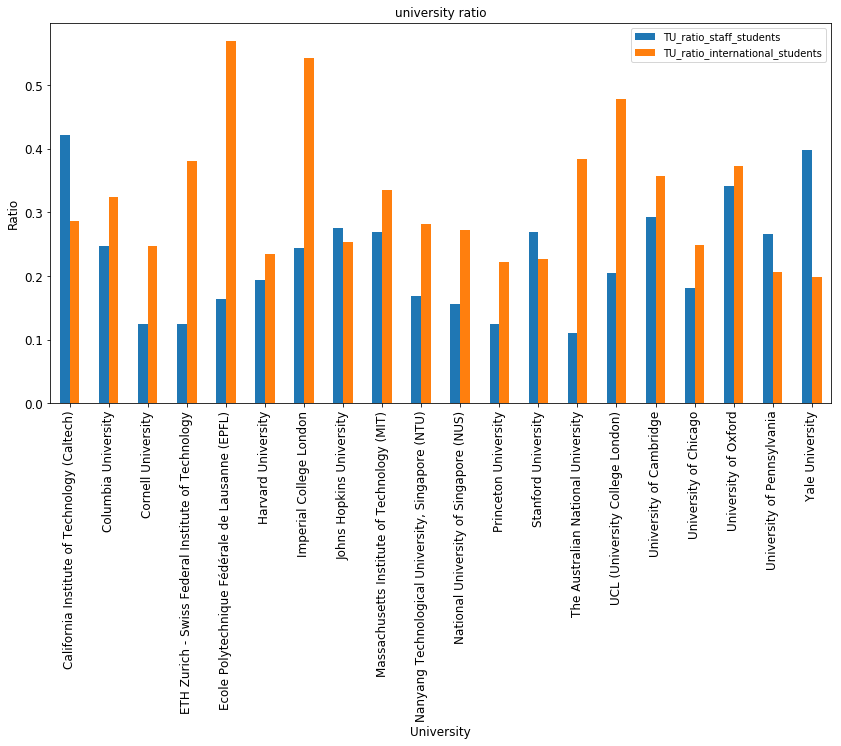

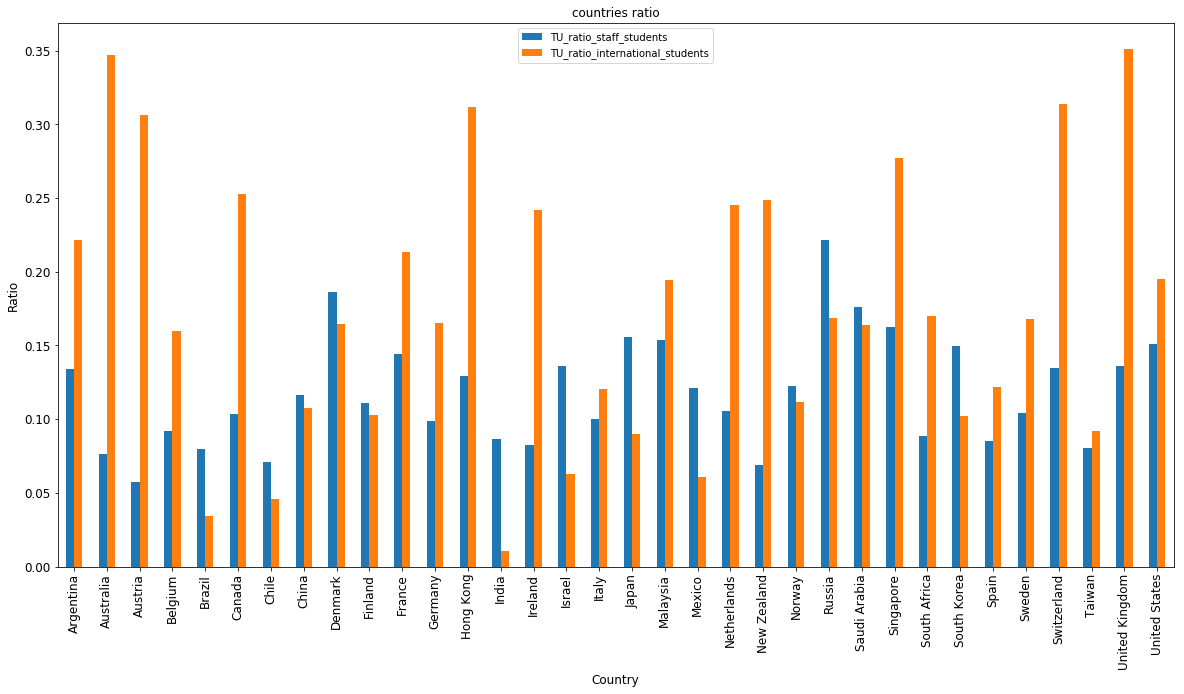

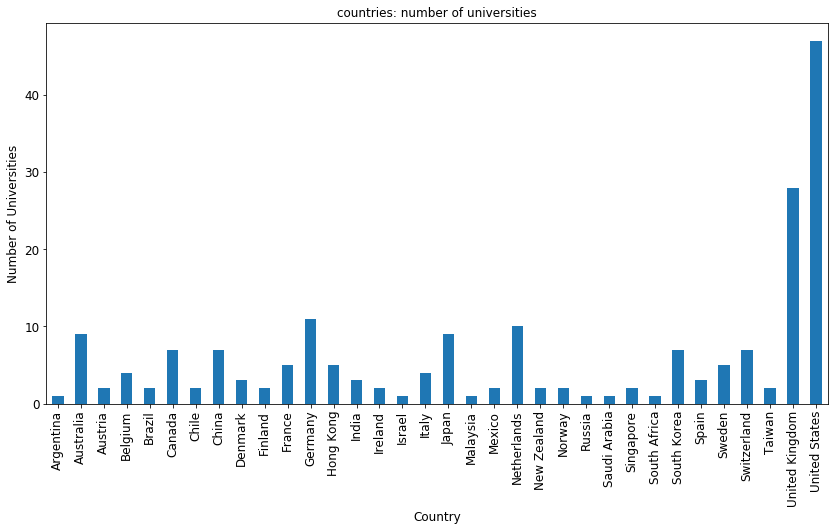

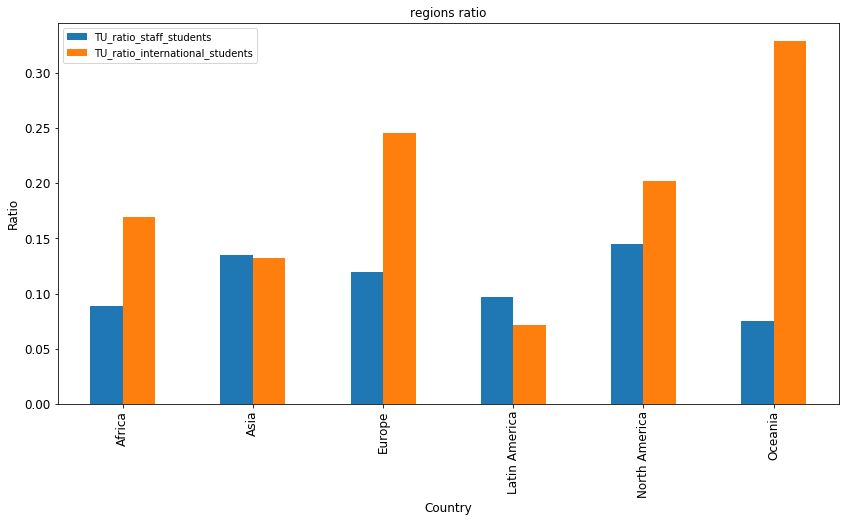

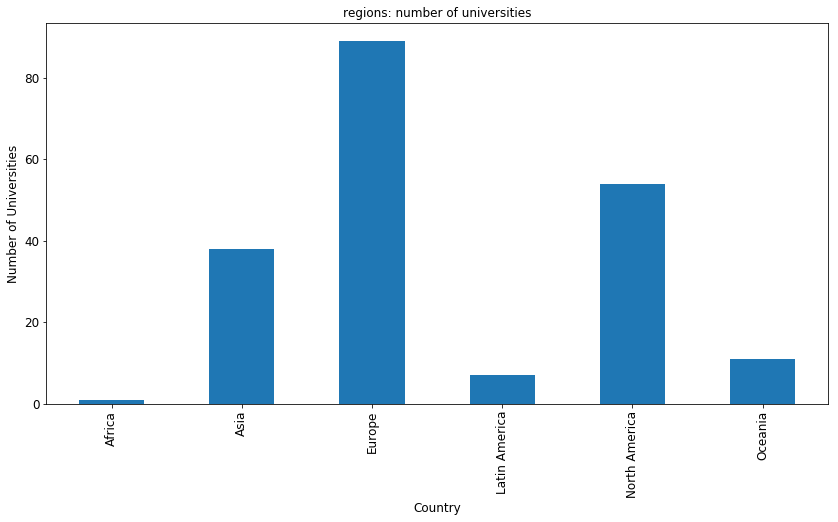

In [90]:
ax_universities = top_univ_df[:20].groupby("name").mean()[["TU_ratio_staff_students", 'TU_ratio_international_students']].plot(kind='bar', title="university ratio", legend=True, fontsize=12, figsize=(14, 7))
ax_universities.set_xlabel("University", fontsize=12)
ax_universities.set_ylabel("Ratio", fontsize=12)
plt.show()

ax_countries = top_univ_df.groupby("TU_country").mean()[["TU_ratio_staff_students", 'TU_ratio_international_students']].plot(kind='bar', title="countries ratio", legend=True, fontsize=12, figsize=(20, 10))
ax_countries.set_xlabel("Country", fontsize=12)
ax_countries.set_ylabel("Ratio", fontsize=12)
plt.show()

ax_countUni = top_univ_df.groupby("TU_country").count()[["TU_rank"]].plot(kind='bar', title="countries: number of universities", legend=False, fontsize=12, figsize=(14, 7))
ax_countUni.set_xlabel("Country", fontsize=12)
ax_countUni.set_ylabel("Number of Universities", fontsize=12)
plt.show()

ax_countries = top_univ_df.groupby("TU_region").mean()[["TU_ratio_staff_students", 'TU_ratio_international_students']].plot(kind='bar', title="regions ratio", legend=True, fontsize=12, figsize=(14, 7))
ax_countries.set_xlabel("Country", fontsize=12)
ax_countries.set_ylabel("Ratio", fontsize=12)
plt.show()

ax_countUni = top_univ_df.groupby("TU_region").count()[["TU_rank"]].plot(kind='bar', title="regions: number of universities", legend=False, fontsize=12, figsize=(14, 7))
ax_countUni.set_xlabel("Country", fontsize=12)
ax_countUni.set_ylabel("Number of Universities", fontsize=12)
plt.show()

**Observations from the plots**

- from the "countries: number of universities" it stands out how U.S.A. and the United Kingdom prevail in the rankings
- from the "regions ratio" plots is interesting to note that Oceania prevails in the number of international students, this is due to the high internationality of the university in Australia.
- from the "regions: number of universities" we can have a clear vision about the relation of the first two regions in terms of number of universities in the ranking, Europe has almost half more than the United States.

### Times Higher Education Scraping

#### Scraping

- We make a request to the url containing all the data. It is a json file, and we put it in the variable page_body. Then we create a dataframe with those data and we rename the columns as we preferred. Finally, we take only the columns we need.

In [91]:
r = requests.get(URL_tim_high)
page_body = r.json()

times_edu_df = pd.DataFrame.from_records(page_body.get("data"))


# Missing region and faculty members international
times_edu_df = times_edu_df.rename(index=str, columns={"aliases": "name2",
                                               "location": "country",
                                               "stats_number_students": "number_of_students",
                                               "stats_pc_intl_students": "int_student/total",
                                               "stats_student_staff_ratio": "student/staff"})

times_edu_df = times_edu_df[["name", "rank", "country", "number_of_students", "int_student/total", "student/staff"]]

#### Fixing the data

- We do all the common operations (transforming strings to float, replacing wrong divisors and wrong characters). Then we choose only the 200 best universities and we set the name of the universities as index of the dataframe.

In [92]:
# Inverse of the ratio from student/staff to staff/student
times_edu_df["student/staff"] = times_edu_df["student/staff"].apply(pd.to_numeric)
times_edu_df["staff/student"] = 1 / times_edu_df["student/staff"]
times_edu_df = times_edu_df.drop("student/staff", axis=1)

# Replacing commas with nothing (commas used as divisor of thousands)
times_edu_df.number_of_students = times_edu_df.number_of_students.apply(lambda x: int(x.replace(',', '')))

# Eliminating the % sign and creating percentages
times_edu_df["int_student/total"] = times_edu_df["int_student/total"].apply(lambda x: int(x.replace('%', '')) / 100)

# Creating the number of international students from the number of students and ratio with internationals
times_edu_df["number_international_students"] = (times_edu_df.number_of_students * times_edu_df["int_student/total"]).apply(int)

# Taking only the digits from the rank column
times_edu_df["rank"] = times_edu_df["rank"].apply(lambda row: pd.to_numeric(re.sub("\D", "", row)))

# Choosing only the best 200 universities
times_edu_df = times_edu_df[:200]

# Setting the name of the university as index
times_edu_df = times_edu_df.set_index("name")

In [93]:
times_edu_df.head(4)

,rank,country,number_of_students,int_student/total,staff/student,number_international_students
name,,,,,,
University of Oxford,1,United Kingdom,20409,0.38,0.089286,7755
University of Cambridge,2,United Kingdom,18389,0.35,0.091743,6436
California Institute of Technology,3,United States,2209,0.27,0.153846,596
Stanford University,3,United States,15845,0.22,0.133333,3485


#### Best Universities and Countries

- Best Universities for ratio international_students/students

In [94]:
times_edu_df.sort_values(by="int_student/total", ascending=False).head(10)

,rank,country,number_of_students,int_student/total,staff/student,number_international_students
name,,,,,,
London School of Economics and Political Science,25,United Kingdom,10065,0.71,0.081967,7146
University of Luxembourg,179,Luxembourg,4969,0.57,0.068493,2832
École Polytechnique Fédérale de Lausanne,38,Switzerland,9928,0.55,0.089286,5460
Imperial College London,8,United Kingdom,15857,0.55,0.087719,8721
Maastricht University,103,Netherlands,16727,0.50,0.055556,8363
University College London,16,United Kingdom,30304,0.49,0.095238,14848
University of St Andrews,143,United Kingdom,9005,0.48,0.076923,4322
Carnegie Mellon University,24,United States,12676,0.45,0.074074,5704
Queen Mary University of London,121,United Kingdom,15405,0.45,0.075188,6932


- Best Universities for ratio international_students/students

In [95]:
times_edu_df.sort_values(by="int_student/total", ascending=False).head(10)

,rank,country,number_of_students,int_student/total,staff/student,number_international_students
name,,,,,,
London School of Economics and Political Science,25,United Kingdom,10065,0.71,0.081967,7146
University of Luxembourg,179,Luxembourg,4969,0.57,0.068493,2832
École Polytechnique Fédérale de Lausanne,38,Switzerland,9928,0.55,0.089286,5460
Imperial College London,8,United Kingdom,15857,0.55,0.087719,8721
Maastricht University,103,Netherlands,16727,0.50,0.055556,8363
University College London,16,United Kingdom,30304,0.49,0.095238,14848
University of St Andrews,143,United Kingdom,9005,0.48,0.076923,4322
Carnegie Mellon University,24,United States,12676,0.45,0.074074,5704
Queen Mary University of London,121,United Kingdom,15405,0.45,0.075188,6932


- Best Countries for ratio staff/students

In [96]:
times_edu_df.groupby("country").mean().sort_values(by="staff/student", ascending=False).head(10)

,rank,number_of_students,int_student/total,staff/student,number_international_students
country,,,,,
Denmark,123.666667,21370.000000,0.166667,0.160166,3108.666667
Italy,169.500000,602.500000,0.105000,0.138889,66.000000
Russian Federation,194.000000,29236.000000,0.220000,0.136986,6431.000000
Japan,60.000000,24240.500000,0.090000,0.132098,2199.000000
United States,77.322581,27508.596774,0.181774,0.106390,4521.580645
France,144.833333,16563.000000,0.208333,0.099352,3162.166667
China,119.857143,36273.000000,0.085714,0.087420,3268.428571
Taiwan,198.000000,31758.000000,0.080000,0.086957,2540.000000
South Africa,171.000000,20775.000000,0.180000,0.085470,3739.000000


- Best Countries for ratio international_students/students

In [97]:
times_edu_df.groupby("country").mean().sort_values(by="int_student/total", ascending=False).head(10)

,rank,number_of_students,int_student/total,staff/student,number_international_students
country,,,,,
Luxembourg,179.000000,4969.000000,0.570000,0.068493,2832.000000
United Kingdom,110.580645,19240.290323,0.365484,0.074252,6872.419355
Hong Kong,88.600000,15532.600000,0.328000,0.056622,5031.400000
Switzerland,95.142857,15407.428571,0.314286,0.083447,4677.571429
Australia,77.000000,33578.750000,0.307500,0.038233,10475.875000
Singapore,37.000000,28050.500000,0.305000,0.060087,8542.000000
New Zealand,192.000000,30348.000000,0.290000,0.053191,8800.000000
Ireland,117.000000,16157.000000,0.270000,0.043860,4362.000000
Austria,165.000000,35375.000000,0.260000,0.048077,9197.000000


#### Plotting the results

Plotting the ratio staff/student and int_student/total for every universities was really messy (too many universities) so we decided to plot only the best 20. Below are showed the folliwing plot:

- The best 20 universities in terms of ratio staff/student and international students/total students
- The mean of the ratio of staff/student and international students/total students for every country
- The number of universities in the top 200 in every country

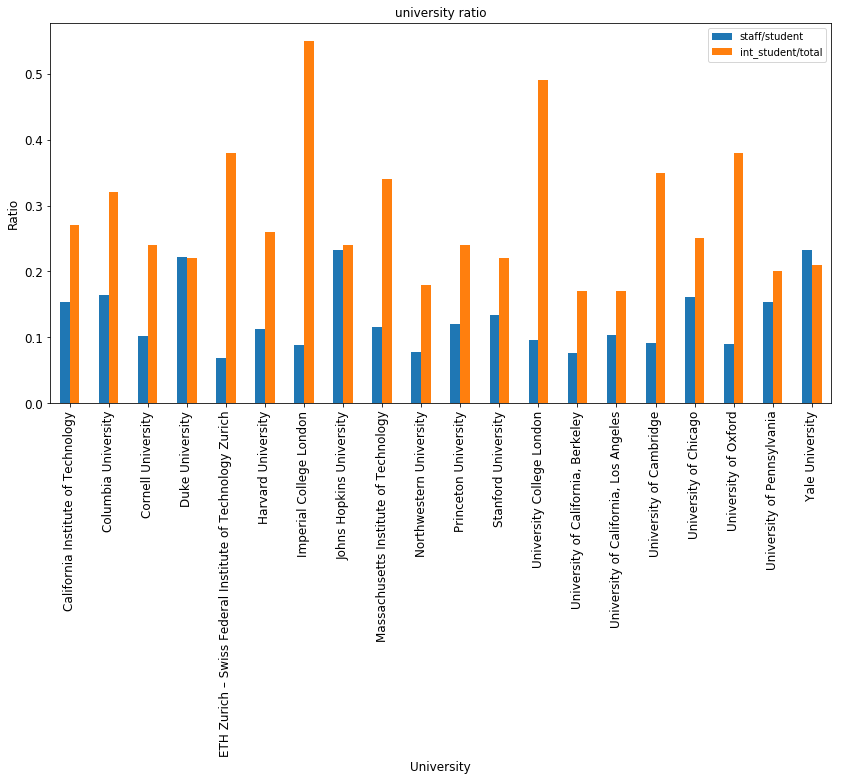

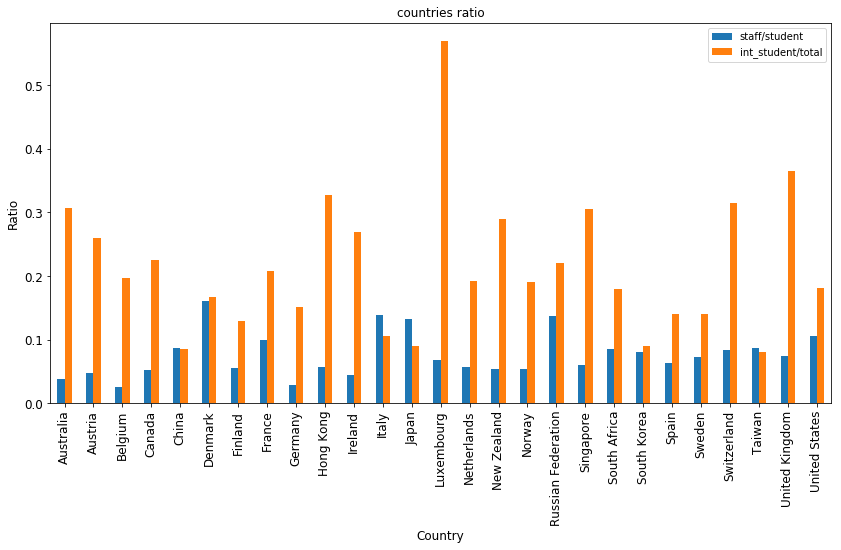

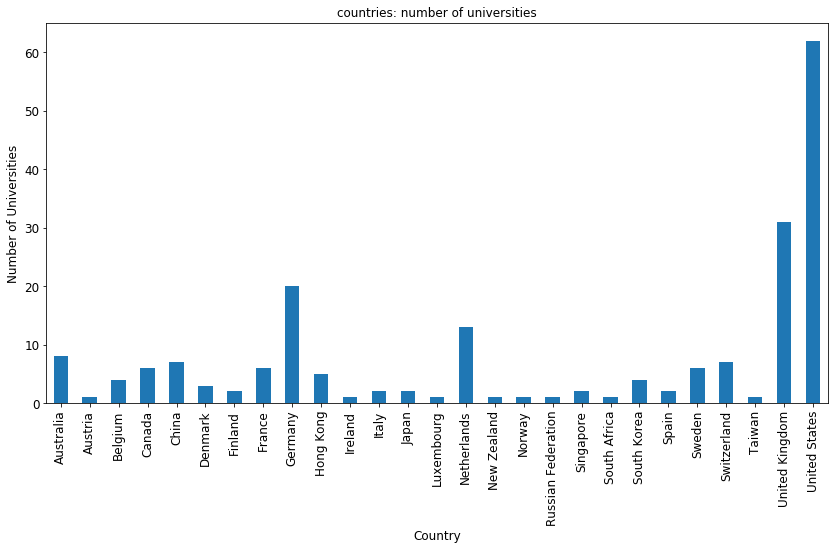

In [98]:
ax_universities = times_edu_df[:20].groupby("name").mean()[["staff/student", "int_student/total"]].plot(kind='bar', title="university ratio", legend=True, fontsize=12, figsize=(14, 7))
ax_universities.set_xlabel("University", fontsize=12)
ax_universities.set_ylabel("Ratio", fontsize=12)
plt.show()

ax_countries = times_edu_df.groupby("country").mean()[["staff/student", "int_student/total"]].plot(kind='bar', title="countries ratio", legend=True, fontsize=12, figsize=(14, 7))
ax_countries.set_xlabel("Country", fontsize=12)
ax_countries.set_ylabel("Ratio", fontsize=12)
plt.show()

ax_countUni = times_edu_df.groupby("country").count()[["rank"]].plot(kind='bar', title="countries: number of universities", legend=False, fontsize=12, figsize=(14, 7))
ax_countUni.set_xlabel("Country", fontsize=12)
ax_countUni.set_ylabel("Number of Universities", fontsize=12)
plt.show()

#### Observation of the plots

- From the "university ratio" plot we can see that London confirms itself as the most international university city. On the other hand, US universities have a greater ratio in terms of number of staff dependents and students.
- From the "countries ratio" plot, Luxembourg clearly put itself to the top as most international country (of course in terms of ratio), followed by UK, Hong Kong, Australia, Singapore and Switzerland. Denmark, Italy, Japan and Russia result to be the best universities when we refer to the ratio staff/student
- From the "countries: number of universities" plot we can notice that the US are on another level as number of universities (60) in the top 200. They are followed by they UK, with only half of the number of universities. It seems right to point out also Germany, with its 20 universities.

#### Last fixing before merging

- Renaming the columns before the merge with the other dataframe.

In [99]:
times_edu_df.rename(columns={"rank": "thEd_rank",
                         "number_of_students": "thEd_number_of_students",
                         "int_student/total": "thEd_int_student/total",
                         "staff/student": "thEd_staff/student",
                         "number_international_students": "thEd_number_international_students"},
              inplace=True)

times_edu_df.head()

,thEd_rank,country,thEd_number_of_students,thEd_int_student/total,thEd_staff/student,thEd_number_international_students
name,,,,,,
University of Oxford,1,United Kingdom,20409,0.38,0.089286,7755
University of Cambridge,2,United Kingdom,18389,0.35,0.091743,6436
California Institute of Technology,3,United States,2209,0.27,0.153846,596
Stanford University,3,United States,15845,0.22,0.133333,3485
Massachusetts Institute of Technology,5,United States,11177,0.34,0.114943,3800


Now, we are ready for the next step, merging the two dataframes obtained from the sites by the name of the universities.

### Merging the Dataframes

For this task we tried different solutions before getting the one that you can see in this notebook. It is pretty simple, we begin with a first check of matches using the "get_closes_matches" method of the difflib module, after this we analyzed the result and then we have decided to retrieve all matches with a more specific criteria using the "clean_matches" method that we have already explained. After this, we have a Series of matched names, we add this series to both dataframes of the first and second site in a new column called 'matchID' and than we do the merge considering that column. More specific details below.

- Using the "get_close_matches" we started searching for possible matches among university names between the two dataframe


In [100]:
first_matches = top_univ_df.index.map(lambda x: difflib.get_close_matches(x, times_edu_df.index, n = 1, cutoff=0.70))

#here we create a List of all matched names found so far
first_m = []
for match in first_matches:
    if len(match) > 0:
        first_m.append(match[0])

    else:
        first_m.append(NaN)

- after this initial check for matching the universities names, we found that using a cutoff of 0.70 gave us some false matches due to some repetitions in the names of the universities, at the beginning we tried to raise up the cutoff but it did not worked (we could not get some matches), therefore we thought to not consider some sequences of words in the names and then compare the names, the words to not consider are in the following list. After that we call the clean_matches method that checks for a match with an higher cutoff between the two series that it has as arguments without considering the "false_matches_list".

In [101]:
false_matches_list = ['University', 'University of Technology', 'State University',
             'Institute of Technology', 'National University', 'Technical University',
             'University of ', 'University of Science and Technology', 'Vrije Universiteit']

first_m = pd.Series(first_m)

df_clean_matches = clean_matches(top_univ_df.index, first_m, false_matches_list)

- Here we add a new 'matchID' column to our first site dataframe, this column is fundamental for the final merging


In [138]:
column = pd.Series(df_clean_matches.match)
top_univ_df = top_univ_df.reset_index()
column = column.reindex(top_univ_df.index)

top_univ_df['matchID'] = column

#column = pd.Series(df_clean_matches.match)
#column = column.reindex(top_univ_df.reset_index().index)
#top_univ_df['matchID'] = column

- After this, we add a column with all the matched names from the clean_matches to the dataframe of the second Site (there is no need in calling again the clean_matches on the second dataframe).


In [139]:
times_edu_df['matchID'] = pd.Series(NaN, index=times_edu_df.index)

for name in times_edu_df.index:
    for match in df_clean_matches.match:
        if name is match:
            times_edu_df.loc[name, 'matchID'] = match


#### Last steps

- We now merge the two dataframe on the 'matchID' column, this has given us some repetitions due to the NaN values (non match) in the matchID column, we drop that rows and we append to the final dataframe all the rows of the two sites that do not have a match.

In [140]:
final_df = top_univ_df.merge(times_edu_df, how='outer', left_on='matchID', right_on='matchID')

#here we drop all the repetition from the merging
final_df = final_df.dropna()

final_df = final_df.set_index('matchID')

#here we obtain all the universities from the first and second site that do not have a match
nan_first_site = top_univ_df[top_univ_df.isnull().any(axis=1)]

nan_second_site = times_edu_df[times_edu_df.isnull().any(axis=1)]

#And now we append to our final dataframe all the universities that do not have a match
final_df = final_df.append(nan_first_site)
final_df = final_df.append(nan_second_site)
final_df = final_df.drop(['matchID'], axis = 1)


- Finally we have the merged dataframe, below you can see the head and the tail of the dataframe.

In [141]:
final_df.head(10)

,TU_country,TU_international_staff,TU_international_students,TU_rank,TU_ratio_international_students,TU_ratio_staff_students,TU_region,TU_total_staff,TU_total_students,country,name,thEd_int_student/total,thEd_number_international_students,thEd_number_of_students,thEd_rank,thEd_staff/student
Massachusetts Institute of Technology,United States,1679.0,3717.0,1.0,0.335863,0.269450,North America,2982.0,11067.0,United States,Massachusetts Institute of Technology (MIT),0.34,3800.0,11177.0,5.0,0.114943
Stanford University,United States,2042.0,3611.0,2.0,0.227422,0.269870,North America,4285.0,15878.0,United States,Stanford University,0.22,3485.0,15845.0,3.0,0.133333
Harvard University,United States,1311.0,5266.0,3.0,0.234785,0.193945,North America,4350.0,22429.0,United States,Harvard University,0.26,5284.0,20326.0,6.0,0.112360
California Institute of Technology,United States,350.0,647.0,4.0,0.286918,0.422616,North America,953.0,2255.0,United States,California Institute of Technology (Caltech),0.27,596.0,2209.0,3.0,0.153846
University of Cambridge,United Kingdom,2278.0,6699.0,5.0,0.356899,0.292488,Europe,5490.0,18770.0,United Kingdom,University of Cambridge,0.35,6436.0,18389.0,2.0,0.091743
University of Oxford,United Kingdom,2964.0,7353.0,6.0,0.372870,0.342292,Europe,6750.0,19720.0,United Kingdom,University of Oxford,0.38,7755.0,20409.0,1.0,0.089286
Imperial College London,United Kingdom,2071.0,8746.0,8.0,0.543567,0.244251,Europe,3930.0,16090.0,United Kingdom,Imperial College London,0.55,8721.0,15857.0,8.0,0.087719
University of Chicago,United States,635.0,3379.0,9.0,0.249244,0.180645,North America,2449.0,13557.0,United States,University of Chicago,0.25,3381.0,13525.0,9.0,0.161290
ETH Zurich – Swiss Federal Institute of Technology Zurich,Switzerland,1886.0,7563.0,10.0,0.381681,0.125006,Europe,2477.0,19815.0,Switzerland,ETH Zurich - Swiss Federal Institute of Techno...,0.38,7308.0,19233.0,10.0,0.068493
"Nanyang Technological University, Singapore",Singapore,2993.0,7251.0,11.0,0.281724,0.168545,Asia,4338.0,25738.0,Singapore,"Nanyang Technological University, Singapore (NTU)",0.31,7904.0,25499.0,52.0,0.061350


In [142]:
final_df.tail(10)

,TU_country,TU_international_staff,TU_international_students,TU_rank,TU_ratio_international_students,TU_ratio_staff_students,TU_region,TU_total_staff,TU_total_students,country,name,thEd_int_student/total,thEd_number_international_students,thEd_number_of_students,thEd_rank,thEd_staff/student
University of Miami,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,NaN,0.16,2537.0,15860.0,186.0,0.169492
University of Dundee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom,NaN,0.24,2614.0,10893.0,187.0,0.067114
University of East Anglia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom,NaN,0.30,4056.0,13521.0,188.0,0.073529
University of Massachusetts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,NaN,0.14,8292.0,59230.0,191.0,0.075188
Northeastern University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,NaN,0.32,6009.0,18780.0,193.0,0.071429
Tilburg University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Netherlands,NaN,0.13,1005.0,7738.0,195.0,0.044444
Paris-Sorbonne University – Paris 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,0.15,3306.0,22042.0,196.0,0.033113
"Royal Holloway, University of London",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom,NaN,0.40,3572.0,8931.0,197.0,0.064935
"University of California, Riverside",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,NaN,0.14,2903.0,20740.0,198.0,0.048309
University of Gothenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sweden,NaN,0.13,2389.0,18378.0,198.0,0.100000


- As you can imagine due to the order of the append before, at the end we have all the universities from the second site that do not have a match in the first Site (all the columns regarding the first site have NaN values).

## 4.
###### Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created?

The first thing we do is compute the pairwise correlations in "variance-covariance-matrix" style.

In [189]:
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
# df = pd.read_csv('Data/final_df.csv', encoding='latin1') # If things don't work, load this as failsafe.
df = final_df.copy()
df = df.reset_index().rename(columns = {'index':'Name'})

Note that we temporarily invert rank values before computing correlations. This since #1 is best (more not better). So if we do not do this a variable that is highly correlated with a good rank would be negative, which is un-intuitive.

In [235]:
df1 = df.copy().iloc[:, [2, 3, 4, 5, 6, 8, 9]]
df1.columns = ['international_staff', 'international_students', 'rank', 'ratio_int_students', 'raio_staff_students', 'total_staff', 'total_students']
df1 = df1.dropna()
old_rank = df1['rank']

# Invert rank values since #1 is best (more not better), else correlations with highter rank will be negative.
df1['rank'] = pd.Series([199] * 199) - df1['rank']
corr_mat = df1.corr()
df['rank'] = old_rank # And change it back
corr_mat

,international_staff,international_students,rank,ratio_int_students,raio_staff_students,total_staff,total_students
international_staff,1.000000,0.641201,0.531224,0.424591,0.325857,0.590219,0.307161
international_students,0.641201,1.000000,0.298645,0.534978,-0.180982,0.467520,0.554956
rank,0.531224,0.298645,1.000000,0.352979,0.415310,0.309343,0.037342
ratio_int_students,0.424591,0.534978,0.352979,1.000000,0.125865,-0.081342,-0.184064
raio_staff_students,0.325857,-0.180982,0.415310,0.125865,1.000000,0.259008,-0.319255
total_staff,0.590219,0.467520,0.309343,-0.081342,0.259008,1.000000,0.762740
total_students,0.307161,0.554956,0.037342,-0.184064,-0.319255,0.762740,1.000000


To easier locate the high correlations we can plot this matrix as a heatmap.

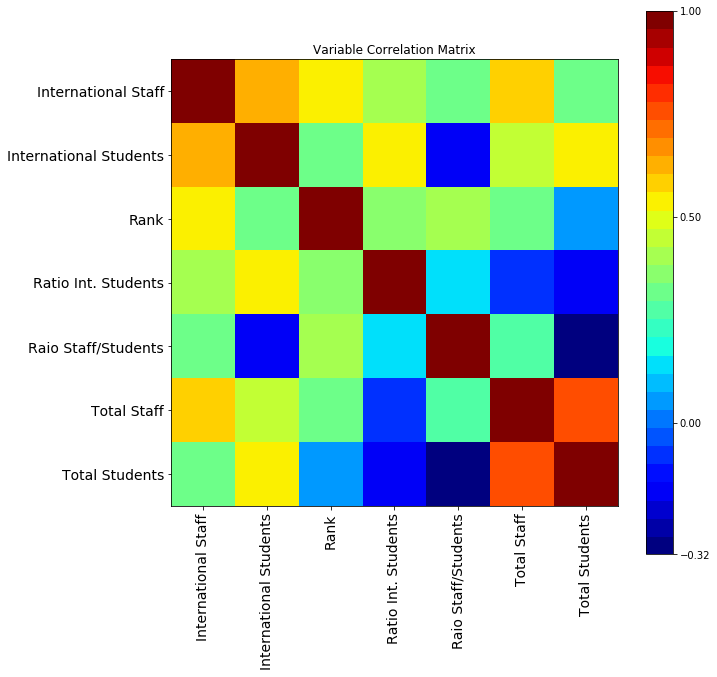

In [236]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(corr_mat, interpolation="nearest", cmap=cmap)
ax1.grid(False)
plt.title('Variable Correlation Matrix')
labels=['', 'International Staff', 'International Students', 'Rank', 'Ratio Int. Students', 'Raio Staff/Students', 'Total Staff', 'Total Students']
ax1.set_xticklabels(labels,fontsize=14)
ax1.set_yticklabels(labels,fontsize=14)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax, ticks=[-0.319255, 0, 0.5, 1])

for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

plt.show()

Comments on the correlations.
* Total staff and total students is strongly correlated, which is not very suprising.
* More total students is correlated with a smaller (note the negative correlation) staff/student ratio. So the totals of staff and students do not grow at equal pace.
* A higher ratio of international students is tied to a better rank. Or conversely, a better rank might attract more international students. I would say it goes both ways; better rank attracks more int. students which in turn improves the rank of the uni, which in turn... and so on.

## 5.
_**Can you find the best university taking in consideration both rankings? Explain your approach.**_


Instead of just averaging the rankings from the two rankings we decided to also incur a score penalty based on the ranking difference between the lists.  
To be more precice, we score the the universiteis according to

$$ \text{score} = \frac{\text{rank}_\text{TU} + \text{rank}_\text{THE}}{2} + \ln\left(\lvert\text{rank}_\text{TU} - \text{rank}_\text{THE}\rvert\right) $$

and then rank them from highest to lowest score.


In [151]:
def score(row):
    #print(row)
    r_TU = row['TU_rank'] if pd.notnull(row['TU_rank']) else 0
    r_THE = row['thEd_rank'] if pd.notnull(row['thEd_rank']) else 0
    
    #print('{} - {} , {}'.format(row.Name, row.TU_rank, row.thEd_rank))
    
    rank_diff = math.fabs(r_TU - r_THE)
    rank_diff = rank_diff if rank_diff != 0 else 1

    scr = (r_TU + r_THE)/2 + math.log(rank_diff)
    return round(scr, 2)

rf = pd.DataFrame({'Name': df.Name, 'Score':df.apply(score, axis=1)})
rf = rf.sort_values('Score')
rf = rf.reset_index().drop('index', axis=1)
rf.index += 1
rf.index.name = 'Rank'
rf

,Name,Score
Rank,,
1,Stanford University,2.50
2,California Institute of Technology,3.50
3,Massachusetts Institute of Technology,4.39
4,University of Cambridge,4.60
5,University of Oxford,5.11
6,6,5.45
7,Harvard University,5.60
8,Imperial College London,8.00
9,University of Chicago,9.00


That's it for this homework! Has been interesting to work with a familiar dataset!